In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

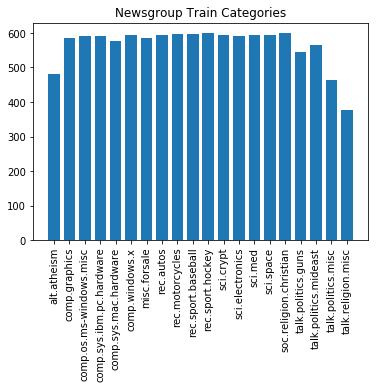

In [4]:
# ---------------
# QUESTION 1
# 20 Newsgroups
# ---------------
import numpy as np
import matplotlib.pyplot as plt
[hist,bin_edges]=np.histogram(newsgroups_train.target,bins=20)
x_int = np.arange(len(newsgroups_train.target_names))
plt.bar(x_int,hist[:],.75)
plt.title('Newsgroup Train Categories')
plt.xticks(x_int,newsgroups_train.target_names,rotation=90)
plt.show()

In [2]:
# -----------------------------------------------------------------------------
# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=3, stop_words='english')
stop_words_english=vectorizer.get_stop_words()

from nltk import pos_tag
import nltk
#nltk.download()

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(list_word)]

analyzer = CountVectorizer().build_analyzer()

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in stop_words_english and not word.isdigit())
    #return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())


In [6]:
# ---------------
# QUESTION 2
# Feature extraction using 
# Bag of Words
# Term Frequency-Inverse Document Frequency (TF-IDF)
# ---------------
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset_trn = fetch_20newsgroups(subset='train',categories=categories,
                                   shuffle=True, random_state=42)
dataset_tst = fetch_20newsgroups(subset='test',categories=categories,
                                   shuffle=True, random_state=42)

In [7]:
vect_trn = CountVectorizer(min_df=3,analyzer=stem_rmv_punc,stop_words='english')
vect_tst = CountVectorizer(min_df=3,analyzer=stem_rmv_punc,stop_words='english')

X_vect_trn = vect_trn.fit_transform(dataset_trn.data)
X_vect_tst = vect_tst.fit_transform(dataset_tst.data)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer_trn = TfidfTransformer()
tfidf_transformer_tst = TfidfTransformer()
X_vect_trn_tfidf = tfidf_transformer_trn.fit_transform(X_vect_trn)
X_vect_tst_tfidf = tfidf_transformer_tst.fit_transform(X_vect_tst)
print(X_vect_trn_tfidf.shape)
print(X_vect_tst_tfidf.shape)

(4732, 16319)
(3150, 11243)


In [10]:
# ---------------
# QUESTION 3
# Dimensional Reduction with: 
# Latent Semantic Indexing (LSI) 
# and 
# Non-negative Matrix Factorization (NMF)
# ---------------

# Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
X_trn_LSI = svd.fit_transform(X_vect_trn_tfidf)
X_tst_LSI = svd.fit_transform(X_vect_tst_tfidf)
print('LSI:')
print(X_trn_LSI.shape)
print(X_tst_LSI.shape)

from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X_vect_trn_tfidf,n_components=50)
Smat = np.identity(50) * Sigma
print(U.shape)
print(Smat.shape)
print(VT.shape)

min_LSI = np.linalg.norm(X_vect_trn_tfidf - np.matmul(np.matmul(U,Smat),VT))
print(min_LSI)

LSI:
(4732, 50)
(3150, 50)
(4732, 50)
(50, 50)
(50, 16319)
64.0505837928


In [11]:
# Also reduce dimensionlaity through NMF 
from sklearn.decomposition import NMF

nmf_trn = NMF(n_components=50, init='random', random_state=0)
nmf_tst = NMF(n_components=50, init='random', random_state=0)
W_trn_NMF = nmf_trn.fit_transform(X_vect_trn_tfidf)
W_tst_NMF = nmf_tst.fit_transform(X_vect_tst_tfidf)
print(type(W_trn_NMF))

<class 'numpy.ndarray'>


In [12]:

print('NMF:')
print(W_trn_NMF.shape)
print(W_tst_NMF.shape)

H_trn_NMF = nmf_trn.components_
print(H_trn_NMF.shape)
W = np.array(W_trn_NMF)
H = np.array(H_trn_NMF)
X = np.array(X_vect_trn_tfidf.toarray())
print(W.shape)
print(H.shape)
print(X.shape)
min_NMF = np.linalg.norm(X - np.matmul(W,H))
print(min_NMF)


NMF:
(4732, 50)
(3150, 50)
(50, 16319)
(4732, 50)
(50, 16319)
(4732, 16319)
64.3674139304


In [13]:
# and compare with LSI

print('LSI:')
print(min_LSI)
print('NMF:')
print(min_NMF)

LSI:
64.0505837928
NMF:
64.3674139304


In [14]:
# ---------------
# QUESTION 4
# Linear Support Vector Machines (SVM) 
# ---------------

# combine documents
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset_trn_01 = fetch_20newsgroups(subset='train',categories=categories,
                                   shuffle=True, random_state=42)
dataset_tst_01 = fetch_20newsgroups(subset='test',categories=categories,
                                   shuffle=True, random_state=42)

i = 0
for t in dataset_trn_01.target:
    if t < 4:
        dataset_trn_01.target[i] = 0
    else:
        dataset_trn_01.target[i] = 1
    i=i+1
i = 0
for t in dataset_tst_01.target:
    if t < 4:
        dataset_tst_01.target[i] = 0
    else:
        dataset_tst_01.target[i] = 1
    i=i+1

print('--')
print(np.unique(np.array(dataset_trn.target)))
print(np.unique(np.array(dataset_tst.target)))
print(np.unique(np.array(dataset_trn_01.target)))
print(np.unique(np.array(dataset_tst_01.target)))



--
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[0 1]
[0 1]


In [15]:
X_trn = X_trn_LSI
y_trn = dataset_trn_01.target
X_tst = X_tst_LSI
y_tst = dataset_tst_01.target

from sklearn import svm
svm_hard = svm.SVC(C=1000, kernel='linear', random_state = 15, probability = True)
svm_soft = svm.SVC(C=.0001, kernel='linear', random_state = 15, probability = True)

svm_hard.fit(X_trn,y_trn)
svm_soft.fit(X_trn,y_trn)

print(svm_hard)
print(svm_soft)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)
SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)


In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)
    
    if hasattr(pipe,'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)

    plot_roc(fpr, tpr)
    return pipe


SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)

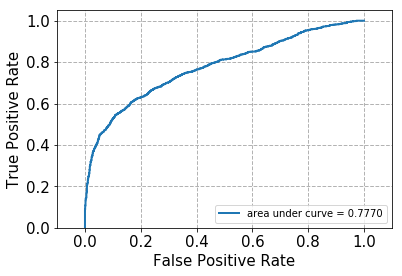

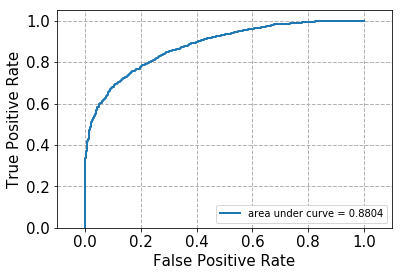

In [17]:
fit_predict_and_plot_roc(svm_hard, X_trn, y_trn, X_tst, y_tst)
fit_predict_and_plot_roc(svm_soft, X_trn, y_trn, X_tst, y_tst)

In [18]:
from sklearn.metrics import confusion_matrix
y_pred_hard = svm_hard.predict(X_tst)
y_pred_soft = svm_soft.predict(X_tst)

#score_hard = clf_hard.score(X_tst,y_tst)
#score_soft = clf_soft.score(X_tst,y_tst)
conf_mat_hard = confusion_matrix(y_tst, y_pred_hard)
conf_mat_soft = confusion_matrix(y_tst, y_pred_soft)

print("confusion matrix, hard =" )
print(conf_mat_hard)
print("confusion matrix, soft =")
print(conf_mat_soft)

confusion matrix, hard =
[[1365  195]
 [ 705  885]]
confusion matrix, soft =
[[   0 1560]
 [   0 1590]]


In [19]:
from sklearn.metrics import accuracy_score

acrcy_hard = accuracy_score(y_tst, y_pred_hard)
acrcy_soft = accuracy_score(y_tst, y_pred_soft)

print("accuracy, hard = %f" % (acrcy_hard))
print("accuracy, soft = %f" % (acrcy_soft))

accuracy, hard = 0.714286
accuracy, soft = 0.504762


In [20]:
from sklearn.metrics import recall_score

recall_hard = recall_score(y_tst, y_pred_hard)
recall_soft = recall_score(y_tst, y_pred_soft)

print("recall, hard = %f" % (recall_hard))
print("recall, soft = %f" % (recall_soft))

recall, hard = 0.556604
recall, soft = 1.000000


In [21]:
from sklearn.metrics import precision_score

precis_hard = precision_score(y_tst, y_pred_hard)
precis_soft = precision_score(y_tst, y_pred_soft)

print("precision, hard = %f" % (precis_hard))
print("precision, soft = %f" % (precis_soft))

precision, hard = 0.819444
precision, soft = 0.504762


In [22]:
from sklearn.metrics import f1_score

f1_hard = f1_score(y_tst, y_pred_hard)
f1_soft = f1_score(y_tst, y_pred_soft)

print("f1 score, hard = %f" % (f1_hard))
print("f1 score, soft = %f" % (f1_soft))


f1 score, hard = 0.662921
f1 score, soft = 0.670886


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = 5
k = np.arange(-3,4)  
gamma = np.power(10.0,k)
cross_val = KFold(n_splits = cv)
for g in gamma:
    svm_g = svm.SVC(C=g, kernel='linear', random_state = 15, probability = True)
    
    print(svm_g)
    scores_g = cross_val_score(svm_g, X_trn, y_trn, cv=cross_val)
    print(np.average(scores_g))


SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)
0.491136581304
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)
0.491347997794
SVC(C=0.10000000000000001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)
0.96830047485
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=15, shrinking=True,
  tol=0.001, verbose=False)
0.971469936218
SVC(C=10.0, cache_size

confusion matrix, gamma = 10:
[[1402  158]
 [ 678  912]]
accuracy,  gamma = 10: 0.734603
recall,    gamma = 10: 0.573585
precision, gamma = 10: 0.852336
f1 score,  gamma = 10: 0.685714


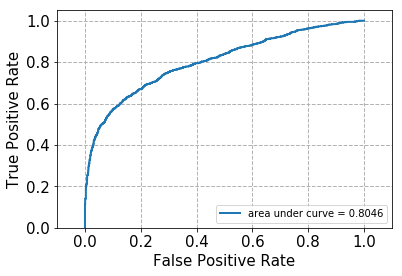

In [24]:
svm_10  = svm.SVC(C=10, kernel='linear', random_state = 15, probability = True)
fit_predict_and_plot_roc(svm_10, X_trn, y_trn, X_tst, y_tst)

y_pred_10 = svm_10.predict(X_tst)

conf_mat_10 = confusion_matrix(y_tst, y_pred_10)
print("confusion matrix, gamma = 10:" )
print(conf_mat_10)
acrcy_10 = accuracy_score(y_tst, y_pred_10)
print("accuracy,  gamma = 10: %f" % (acrcy_10))
recall_10 = recall_score(y_tst, y_pred_10)
print("recall,    gamma = 10: %f" % (recall_10))
precis_10 = precision_score(y_tst, y_pred_10)
print("precision, gamma = 10: %f" % (precis_10))
f1_10 = f1_score(y_tst, y_pred_10)
print("f1 score,  gamma = 10: %f" % (f1_10))

In [25]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_trn,y_trn)

print(LR)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


confusion matrix, Log Reg:
[[1391  169]
 [ 592  998]]
accuracy,         Log Reg: 0.758413
recall,           Log Reg: 0.627673
precision,        Log Reg: 0.855184
f1 score,         Log Reg: 0.723975


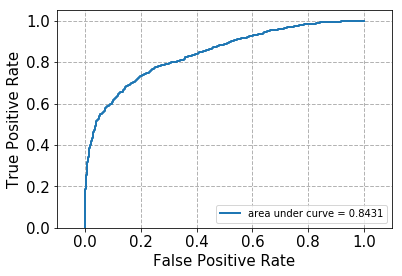

In [32]:
# ---------------
# QUESTION 5
# Logistic Classifier
# ---------------
fit_predict_and_plot_roc(LR, X_trn, y_trn, X_tst, y_tst)

y_pred_LR = LR.predict(X_tst)

conf_mat_LR = confusion_matrix(y_tst, y_pred_LR)
print("confusion matrix, Log Reg:" )
print(conf_mat_LR)
acrcy_LR = accuracy_score(y_tst, y_pred_LR)
print("accuracy,         Log Reg: %f" % (acrcy_LR))
recall_LR = recall_score(y_tst, y_pred_LR)
print("recall,           Log Reg: %f" % (recall_LR))
precis_LR = precision_score(y_tst, y_pred_LR)
print("precision,        Log Reg: %f" % (precis_LR))
f1_LR = f1_score(y_tst, y_pred_LR)
print("f1 score,         Log Reg: %f" % (f1_LR))

In [38]:
cv = 5
k = np.arange(-3,4)  
reg_strength = np.power(10.0,k)
cross_val = KFold(n_splits = cv)
strength_L1 = 0
strength_L2 = 0
score_max_L1 = 0
score_max_L2 = 0
for r in reg_strength:
    C = 1/r # C is Invers of regularization strength
    LR_L1_r = LogisticRegression(penalty = 'l1', C=1/r)
    LR_L2_r = LogisticRegression(penalty = 'l2', C=1/r)
    print('--')
    print(LR_L1_r)
    print(LR_L2_r)
    scores_L1_r = cross_val_score(LR_L1_r, X_trn, y_trn, cv=cross_val)
    scores_L2_r = cross_val_score(LR_L2_r, X_trn, y_trn, cv=cross_val)
    score_L1 = np.average(scores_L1_r)
    score_L2 = np.average(scores_L2_r)
    print("Strength: %f" % r)
    print("Avg Score, L1: %f" % score_L1)
    print("Avg Score, L2: %f" % score_L2)
    print('--')
    if score_L1 > score_max_L1:
        score_max_L1 = score_L1
        strength_L1 = C
    if score_L2 > score_max_L2:
        score_max_L2 = score_L2
        strength_L2 = C

print('Best Strength, L1 = %f' % strength_L1)
print('Best Strength, L2 = %f' % strength_L2)

--
LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Strength: 0.001000
Avg Score, L1: 0.974640
Avg Score, L2: 0.974851
--
--
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10

In [40]:
# for no regularization, you can just set C very large so lambda approaches 0
LR_none = LogisticRegression(penalty = 'l2', C=999999)
LR_L1   = LogisticRegression(penalty = 'l1', C=1/strength_L1)
LR_L2   = LogisticRegression(penalty = 'l2', C=1/strength_L2)
print(LR_none)
print(LR_L1)
print(LR_L2)

LogisticRegression(C=999999, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


confusion matrix, Log Reg, no reg:
[[1364  196]
 [ 700  890]]
confusion matrix, Log Reg, L1:
[[1478   82]
 [ 522 1068]]
confusion matrix, Log Reg, L2:
[[1364  196]
 [ 446 1144]]
--
accuracy, Log Reg, no reg: 0.715556
accuracy, Log Reg,     L1: 0.808254
accuracy, Log Reg,     L2: 0.796190
--
recall, Log Reg, no reg: 0.559748
recall, Log Reg,     L1: 0.671698
recall, Log Reg,     L2: 0.719497
--
precision, Log Reg, no reg: 0.819521
precision, Log Reg,     L1: 0.928696
precision, Log Reg,     L2: 0.853731
--
f1 score, Log Reg, no reg: 0.665172
f1 score, Log Reg,     L1: 0.779562
f1 score, Log Reg,     L2: 0.780887
--


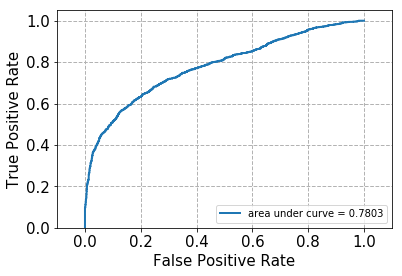

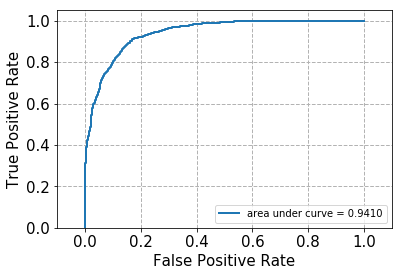

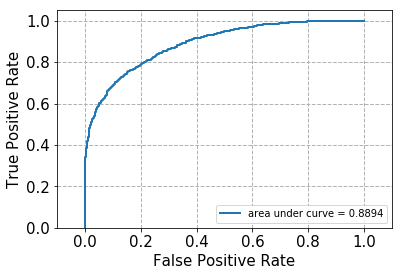

In [41]:
fit_predict_and_plot_roc(LR_none, X_trn, y_trn, X_tst, y_tst)
fit_predict_and_plot_roc(LR_L1,   X_trn, y_trn, X_tst, y_tst)
fit_predict_and_plot_roc(LR_L2,   X_trn, y_trn, X_tst, y_tst)

y_pred_LR_none = LR_none.predict(X_tst)
y_pred_LR_L1   = LR_L1.predict(X_tst)
y_pred_LR_L2   = LR_L2.predict(X_tst)

print("confusion matrix, Log Reg, no reg:" )
print(confusion_matrix(y_tst, y_pred_LR_none))
print("confusion matrix, Log Reg, L1:" )
print(confusion_matrix(y_tst, y_pred_LR_L1))
print("confusion matrix, Log Reg, L2:" )
print(confusion_matrix(y_tst, y_pred_LR_L2))
print('--')
print("accuracy, Log Reg, no reg: %f" % (accuracy_score(y_tst, y_pred_LR_none)))
print("accuracy, Log Reg,     L1: %f" % (accuracy_score(y_tst, y_pred_LR_L1)))
print("accuracy, Log Reg,     L2: %f" % (accuracy_score(y_tst, y_pred_LR_L2)))
print('--')
print("recall, Log Reg, no reg: %f" % (recall_score(y_tst, y_pred_LR_none)))
print("recall, Log Reg,     L1: %f" % (recall_score(y_tst, y_pred_LR_L1)))
print("recall, Log Reg,     L2: %f" % (recall_score(y_tst, y_pred_LR_L2)))
print('--')
print("precision, Log Reg, no reg: %f" % (precision_score(y_tst, y_pred_LR_none)))
print("precision, Log Reg,     L1: %f" % (precision_score(y_tst, y_pred_LR_L1)))
print("precision, Log Reg,     L2: %f" % (precision_score(y_tst, y_pred_LR_L2)))
print('--')
print("f1 score, Log Reg, no reg: %f" % (f1_score(y_tst, y_pred_LR_none)))
print("f1 score, Log Reg,     L1: %f" % (f1_score(y_tst, y_pred_LR_L1)))
print("f1 score, Log Reg,     L2: %f" % (f1_score(y_tst, y_pred_LR_L2)))
print('--')

GaussianNB(priors=None)
confusion matrix, GNB:
[[1238  322]
 [ 623  967]]
accuracy,  GNB: 0.700000
recall,    GNB: 0.608176
precision, GNB: 0.750194
f1 score,  GNB: 0.671761


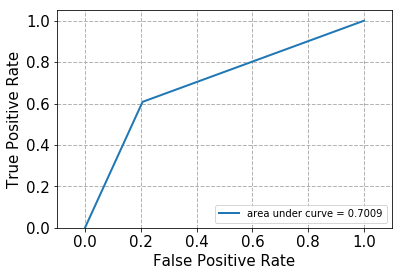

In [42]:
# ---------------
# QUESTION 6
# Naive Bayes
# ---------------
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
print(GNB)

fit_predict_and_plot_roc(GNB, X_trn, y_trn, X_tst, y_tst)

y_pred_GNB = GNB.predict(X_tst)
print("confusion matrix, GNB:" )
print(confusion_matrix(y_tst, y_pred_GNB))
print("accuracy,  GNB: %f" % (accuracy_score(y_tst, y_pred_GNB)))
print("recall,    GNB: %f" % (recall_score(y_tst, y_pred_GNB)))
print("precision, GNB: %f" % (precision_score(y_tst, y_pred_GNB)))
print("f1 score,  GNB: %f" % (f1_score(y_tst, y_pred_GNB)))


In [20]:
# ---------------
# QUESTION 7
# Grid Search with Pipelines
# ---------------
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset_trn_01 = fetch_20newsgroups(subset='train',categories=categories,
                                   shuffle=True, random_state=42)
dataset_tst_01 = fetch_20newsgroups(subset='test',categories=categories,
                                   shuffle=True, random_state=42)
print(np.unique(np.array(dataset_trn_01.target)))
print(np.unique(np.array(dataset_tst_01.target)))
# combine documents
i = 0
for t in dataset_trn_01.target:
    if t < 4:
        dataset_trn_01.target[i] = 0
    else:
        dataset_trn_01.target[i] = 1
    i=i+1
i = 0
for t in dataset_tst_01.target:
    if t < 4:
        dataset_tst_01.target[i] = 0
    else:
        dataset_tst_01.target[i] = 1
    i=i+1

print('--')
print(np.unique(np.array(dataset_trn_01.target)))
print(np.unique(np.array(dataset_tst_01.target)))




[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
--
[0 1]
[0 1]


In [21]:
# Pipeline
# Define a pipeline combining a text feature extractor with a simple
# classifier

# feature extraction

# dimensionality reduction

# classification
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', GaussianNB()),
])
pipeline.fit(dataset_trn_01.data, dataset_trn_01.target)
predict = pipeline.predict(dataset_tst_01.data)
print("accuracy:{}".format(accuracy_score(dataset_tst_01.target, predict)))

accuracy:0.9044444444444445


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk import pos_tag
import nltk


wnl = nltk.wordnet.WordNetLemmatizer()
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(list_word)]
analyzer = CountVectorizer().build_analyzer()
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())
    #return (word for word in lemmatize_sent(analyzer(doc)) if word not in stop_words_english and not word.isdigit())
    

MIN_DF_OPTIONS = [3, 5]
strength_L1 = 10
strength_L2 = 100

param_grid = [
    {
        'vect': [CountVectorizer(stop_words='english',analyzer=stem_rmv_punc),
                 CountVectorizer(stop_words='english')],
        'vect__min_df': MIN_DF_OPTIONS,
        'tfidf': [TfidfTransformer()],
        'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50, init='random', random_state=42)],
        'clf': [svm.SVC(C=10, kernel='linear', random_state = 15, probability = True),
                LogisticRegression(penalty = 'l1', C=1/strength_L1),
                LogisticRegression(penalty = 'l2', C=1/strength_L2),
                GaussianNB()]
    }]
    
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(dataset_trn_01.data, dataset_trn_01.target)
rmtree(cachedir)

# Loading Data
# remove headers and footers vs not


# Feature Extraction
# min_df = 3 vs 5
# use lemmatiation vs not


# Dimensionality Reduction
# LSI vs. NMF


# Classifier
# SVM with best gamma found vs
# Logistic Regressio: L1 vs. L2 (with best strength) vs
# Gaussian NB


KeyboardInterrupt: 

In [6]:
# ---------------
# QUESTION 8
# Multiclass Classification
# ---------------
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from nltk import pos_tag
import nltk
import pandas as pd

categories = ['comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware',
              'misc.forsale',
              'soc.religion.christian']
dataset_trn = fetch_20newsgroups(subset='train',
                                 categories=categories,
                                 shuffle=True, 
                                 random_state=42,
                                 remove=('headers','footers'))
dataset_tst = fetch_20newsgroups(subset='test',
                                 categories=categories,
                                 shuffle=True, 
                                 random_state=42,
                                 remove=('headers','footers'))


vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc,stop_words='english')

X_train = vect.fit_transform(dataset_trn.data)
X_test  = vect.fit_transform(dataset_tst.data)

y_train = dataset_trn.target
y_test  = dataset_tst.target

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.fit_transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
X_trn_LSI = svd.fit_transform(X_train_tfidf)
X_tst_LSI = svd.fit_transform(X_test_tfidf)



(2352, 6909)
(1565, 5522)


In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn import svm
clf_ovo = svm.SVC(decision_function_shape='ovo')
#clf_ovo.fit(X_trn_LSI, y_train) 

clf_ovr = svm.SVC(decision_function_shape='ovr')
#clf_ovr.fit(X_trn_LSI, y_train) 

clf_ovo.fit(X_trn_LSI, y_train)
clf_ovr.fit(X_trn_LSI, y_train)

y_pred_ovo = clf_ovo.predict(X_tst_LSI)
y_pred_ovr = clf_ovr.predict(X_tst_LSI)

print("confusion matrix, ovo:" )
print(confusion_matrix(y_test, y_pred_ovo))
print("confusion matrix, ovr:" )
print(confusion_matrix(y_test, y_pred_ovr))
print("accuracy,  ovo: %f" % (accuracy_score(y_test, y_pred_ovo)))
print("accuracy,  ovr: %f" % (accuracy_score(y_test, y_pred_ovr)))
print("recall,    ovo: %f" % (recall_score(y_test, y_pred_ovo, average = 'weighted')))
print("recall,    ovr: %f" % (recall_score(y_test, y_pred_ovr, average = 'weighted')))
print("precision, ovo: %f" % (precision_score(y_test, y_pred_ovo, average = 'weighted')))
print("precision, ovr: %f" % (precision_score(y_test, y_pred_ovr, average = 'weighted')))
print("f1 score,  ovo: %f" % (f1_score(y_test, y_pred_ovo, average = 'weighted')))
print("f1 score,  ovr: %f" % (f1_score(y_test, y_pred_ovr, average = 'weighted')))

confusion matrix, ovo:
[[175  17 200   0]
 [176  57 152   0]
 [286   8  96   0]
 [ 15   4  40 339]]
confusion matrix, ovr:
[[175  17 200   0]
 [176  57 152   0]
 [286   8  96   0]
 [ 15   4  40 339]]
accuracy,  ovo: 0.426198
accuracy,  ovr: 0.426198
recall,    ovo: 0.426198
recall,    ovr: 0.426198
precision, ovo: 0.533617
precision, ovr: 0.533617
f1 score,  ovo: 0.431965
f1 score,  ovr: 0.431965


In [31]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
print(MNB)
MNB.fit(X_train_tfidf, y_train) 
print(X_train_tfidf.shape)
print(y_train.shape)
print(X_test_tfidf.shape)

X_test_trnsfrm = vect.transform(dataset_tst)
y_predict = MNB.predict(X_test_trnsfrm)

y_pred_MNB = MNB.predict(X_tst_LSI)
print("confusion matrix, MNB:" )
print(confusion_matrix(y_test, y_pred_MNB))
print("accuracy,  GNB: %f" % (accuracy_score(y_test, y_pred_MNB)))
print("recall,    GNB: %f" % (recall_score(y_test, y_pred_MNB)))
print("precision, GNB: %f" % (precision_score(y_test, y_pred_MNB)))
print("f1 score,  GNB: %f" % (f1_score(y_test, y_pred_MNB)))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
(2352, 6909)
(2352,)
(1565, 5522)


ValueError: dimension mismatch